### Importing libraries

In [108]:
import altair as alt #best library for visualization!
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import Counter

#Importing Models and metrics
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, make_scorer, plot_confusion_matrix, precision_score, recall_score
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree


### Reading Data

In [48]:
df_train = pd.read_csv('train.csv')

## Analyzing Data

I am starting with `.info()` as it gives a quick glance of columns/features along with the datatype(numerical or categorical). Also, gives a headstart with the null values.

In [49]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We have 12 features and handful of null values in `Cabin, Age`.

`.head()` shows a glimpse of dataset to get better understanding about datatype.

In [50]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


`Survived, Sex, Embarked` are categorical and `Pclass` is ordinal.

`Age, Fare, SibSp, Parch` are numerical wherein first two features are continous.

`Cabin` is alphanumeric

Ignoring other features like `PassengerId, Name, Ticket` as they don't effect the outcome.(Do they??)

We can better understanding of each numerical feature with the help of `.describe()`

In [51]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


1. Total passengers count is 891.
2. Survived is categorical but in the form of binary where 1 means survived.
3. Most of the passengers belonged to third class.
4. 75% of the total passengers are below age of 38.
5. Most of the passengers travelled without siblings or spouse.
6. More than 75% passengers tarvelled without parents or childen.
7. Though more than 75% passengers paid below 31$, there are few passengers who paid as high as 512$.


### Outliers

Before we do any analysis, its better to take care of outliers as they might make our assumptions biased.

There are various strategies available to detect outliers. One of the simplest methods is Turkey method. From above `describe()` method, in `Fare` we can see that 75% of people paid 31$. But the max is 512$ which is a drastic increase and it might heavily affect our prediction if `Fare` is an important feature. Turkey method is very helpful to care of such outliers. It considers any observation below 25% and above 75% of the distribution as an outlier. We can vary 25% and 75% using outlier step.

In [52]:
def outliers(df, columns, num):
    """
    We are giving a dataframe (df_train) and specifying which columns/features it has to check for outliers
    and num represents number of outlier columns in each row to be cosidered inorder to declare a row as outlier.
    """
    outlier_idx = []
    for col in columns:
        P25 = np.percentile(df[col], 25) #25%
        P75 = np.percentile(df[col], 75) #75%
        Prange = P75 - P25 #Most values range
        outlier_step = 1.5*Prange #We  are giving a bit leniance for those just out of range
        #Will compare all all values of given column that falls outside of range and step
        list_of_idx = df[(df[col] < P25 - outlier_step) | (df[col] > P75 + outlier_step)].index
        #Will append every iteration index to a common list
        outlier_idx.extend(list_of_idx)
    #Will count no.of times each row has an outlier in its features.
    outlier_idx = Counter(outlier_idx)
    #Given num decides which rows to be removed
    final_outliers = list(i for i, c in outlier_idx.items() if c > num)

    return final_outliers

In [53]:
outliers_list = outliers(df_train, ['Age','SibSp','Parch','Fare'],2)
df_train.loc[outliers_list]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


Looks like rows with very high `SibSp` (8) and `Fare` (263$) are considered outliers.

In [54]:
# df_train = df_train.drop(outliers_list)
# df_train.info()

Out of 891 entries, 10 are outliers. Remaining entries are 881.

### Plotting Analysis

Our main priority is to check which features are highly correleated with survival rate. We can do that using pivoting features or better visualized using plots.

In [55]:
df_train.groupby(['Pclass'],as_index=False)['Survived'].mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


This clearly shows survival rate is more in first and second class.

In [56]:
df_train.groupby(['Sex'],as_index=False)['Survived'].mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


Almost 75% of females and less than 20% men survived.

In [57]:
df_train.groupby(['SibSp','Parch'],as_index=False)['Survived'].mean()

,SibSp,Parch,Survived
0,0,0,0.303538
1,0,1,0.657895
2,0,2,0.724138
3,0,3,1.000000
4,0,4,0.000000
5,0,5,0.000000
6,1,0,0.520325
7,1,1,0.596491
8,1,2,0.631579
9,1,3,0.333333


I can't see a clear correlation between `SibSp` and `Parch` with the survival rate. But will have a detailed look in plot.

#### Visualizing

From above tables, we can see first/second class and women has better survival rate (Nicely done Rose :) ) compared to third class and men (poor Jack '_').

What about `Age` and `Fare`?

In [58]:
alt.Chart(df_train).mark_bar().encode(
    alt.X(alt.repeat("row"),bin=alt.Bin(maxbins=20)),
    y = 'count()',
    color = 'Survived:N',
    tooltip = 'count()'
).repeat(
    row = ['Age', 'Fare']
).interactive()

/home/dhonicap/miniconda3/envs/titanic/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.RepeatChart(...)

The graphs are interactive and hover over the bars to view exact counts (cool!)

Better to look over the passengers who paid more than 100$

In [59]:
df_fare = df_train.loc[df_train['Fare'] > 100,:]
alt.Chart(df_fare).mark_bar().encode(
    alt.X('Fare',bin=alt.Bin(step=50)),
    y = 'count()',
    color = 'Survived:N',
    tooltip = 'count()'
).interactive()

alt.Chart(...)

Seems like most of the high fare payers survived.

#### Dealing with Skewness

We we see the graphs, `Age` looks like a normal distribution but `Fare` appears to be skewed which is not desirable. There are various techniques available to reduce the skewness. If our distribution is right-skewed (positive skewness) i.e mean is larger than median, then we can use square root, cube root and logarithms. Applying log function is mostly preffered but remeber, it can't be used if the data has zero or negative values. Similarly, for left-skewed distributions, techniques like squares, cubes and higher powers can be used.  
For our case, we can apply log transformation.

In [60]:
df_train['Fare'] = df_train['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

In [61]:
bar = alt.Chart(df_train).mark_bar().encode(
    alt.X('Fare',bin=alt.Bin(maxbins=20)),
    y = 'count()',
    color = 'Survived:N'
).interactive()
line = alt.Chart(df_train).mark_line(color = 'red').encode(
    alt.X('Fare',bin=alt.Bin(maxbins=20)),
    y = 'count()'
).interactive()
bar + line


alt.LayerChart(...)

Looks better!

In [62]:
alt.Chart(df_train).mark_bar().encode(
    alt.X(alt.repeat("column"), type = 'nominal'),
    y = 'count()',
    color = 'Survived:N',
    tooltip = 'count()'
).repeat(
    column = ['Pclass','Sex']
).interactive()

alt.RepeatChart(...)

We can confirm `Pclass` and `Sex` clearly impact survival.

In [63]:
alt.Chart(df_train).mark_bar().encode(
    alt.X(alt.repeat("row"), type = 'nominal'),
    y = 'count()',
    color = 'Survived:N',
    tooltip = 'count()'
).repeat(
    row = ['SibSp','Parch']
).interactive()


alt.RepeatChart(...)

It is unclear, but families with less siblings/spouse have better record of surving. From `Parch`, no evident reasoning can be drawn.

In [64]:
alt.Chart(df_train).mark_bar().encode(
    x = 'Embarked',
    y = 'count()',
    color = 'Survived:N',
    tooltip = ['count()','Sex:N']
).interactive()

alt.Chart(...)

From above plots, we can say that `Pclass, Sex` and `Fare` are clearly impacting survival rate. Also, it might not be entirely clear but `Age` and `Embarked` may also be impacting survival rate. `SibSp` and `Parch` features maybe not much useful features but as our dataset is not very large, it wont hurt to keep them around. 
We did not talk about `Cabin` as it has a lot of null values. Trying to fill them and establishing a correlation might lead to errors. So its better to ignore this feature. So we can only include impacting 5 features to build the model.

In [65]:
df_train = df_train.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


#### Dealing with Null values

We know that `Age` is an important feature but it has a few missing values. There are different methods to fill null values. Simplest one is to fill with random values using mean and standard deviation. But a better approach would be figuring out age value using its correlation with other features.

In [66]:
alt.Chart(df_train).mark_boxplot().encode(
    alt.X(alt.repeat("column")),
    y = 'Age:Q'
).repeat(
    column = ['Sex','Pclass','Parch','SibSp']
).interactive()

/home/dhonicap/miniconda3/envs/titanic/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.RepeatChart(...)

From above boxplots, good amount of correlations can be found. Looks like `Sex` is not influencing `Age`. But there seems to be some influence due to `PClass, Parch` and `SibSp`. A correlation matrix might give more detailed information.

`Sex` is in categorical. Inorder to check correlation, will convert it to numerical.

In [67]:
df_train['Sex'] = df_train['Sex'].map({
    'male' :0, 'female' : 1
})

In [68]:
df_train[['Age','Sex','Pclass','SibSp','Parch']].corr()

,Age,Sex,Pclass,SibSp,Parch
Age,1.000000,-0.093254,-0.369226,-0.308247,-0.189119
Sex,-0.093254,1.000000,-0.131900,0.114631,0.245489
Pclass,-0.369226,-0.131900,1.000000,0.083081,0.018443
SibSp,-0.308247,0.114631,0.083081,1.000000,0.414838
Parch,-0.189119,0.245489,0.018443,0.414838,1.000000


Looks like `Age` is negatively correlated wih `Pclass, SibSp` and `Parch`. So I will use meadian age of similar rows according to correlated features.

In [69]:
index_NaN_age = list(df_train["Age"][df_train["Age"].isnull()].index)

for idx in index_NaN_age :
    age_med = df_train["Age"].median()
    age_pred = df_train["Age"][((df_train['SibSp'] == df_train.iloc[idx]["SibSp"]) & (df_train['Parch'] == df_train.iloc[idx]["Parch"]) & (df_train['Pclass'] == df_train.iloc[idx]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        df_train['Age'].iloc[idx] = age_pred
    else :
        df_train['Age'].iloc[idx] = age_med

/tmp/ipykernel_2170/2679776331.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Age'].iloc[idx] = age_pred
/tmp/ipykernel_2170/2679776331.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Age'].iloc[idx] = age_med


In [70]:
df_train['Age'].isnull().sum()

0

### One hot encoding

To deal with categorical values, we use one hot encoding techique. To be more precise, if the data is in numbers, our model might try to establish a relation between the data by treating numbers as some order of relation. This might be helpful in many cases, but not if those numbers represent categories. This is mainly done using `ColumnTranformer()` or `OneHotEncoder` from sklearn or `get_dummies()` form pandas. Column transformer can come handy in cases like when you need to deal with data in the future and it can handle exceptions neatly but it returns the data as an array. Which means, we will loose the column names and is diificult to verify. So instead we will go with `get_dummies()`.

In our data, only `Embarked` needs to be dealt as it has categrical data. Though other columns has categorical data, it is in the form of 1's and 0's (less than 2 categories) which doesn't create an issue.

In [71]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix = 'Em') #Prefix to decrease the name length
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Em_C,Em_Q,Em_S
0,0,3,0,22.0,1,0,1.981001,0,0,1
1,1,1,1,38.0,1,0,4.266662,1,0,0
2,1,3,1,26.0,0,0,2.070022,0,0,1
3,1,1,1,35.0,1,0,3.972177,0,0,1
4,0,3,0,35.0,0,0,2.085672,0,0,1


## Building Models

Our dataset is almost ready to be used to build a ML model. We will split the features and output.

In [72]:
X_train = df_train.drop('Survived', axis=1)
Y_train = df_train['Survived']
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Em_C,Em_Q,Em_S
0,3,0,22.0,1,0,1.981001,0,0,1
1,1,1,38.0,1,0,4.266662,1,0,0
2,3,1,26.0,0,0,2.070022,0,0,1
3,1,1,35.0,1,0,3.972177,0,0,1
4,3,0,35.0,0,0,2.085672,0,0,1
...,...,...,...,...,...,...,...,...,...
886,2,0,27.0,0,0,2.564949,0,0,1
887,1,1,19.0,0,0,3.401197,0,0,1
888,3,1,13.5,1,2,3.154870,0,0,1
889,1,0,26.0,0,0,3.401197,1,0,0


### What model to choose?

We have data and we need to predict whether a passenger survived or not which is nothing but a classification in supervised learning environment.

#### Logistic Regression

It is one of the simplest models in machine learning. Its always good to start with a simple model as we often desire simpler models over complex models.

In [111]:
mod_log = LogisticRegression(max_iter=1000)
mod_log = mod_log.fit(X_train, Y_train)
Y_pred = mod_log.predict(X_train)
accuracy_score(Y_train, Y_pred)

0.8002244668911336

We are using the same train set for training and predicting. We can understand our model performance using cross validation.

In general, k-fold cross validation splits the train and validation sets randomly but sometimes it may lead to poor train set. So insead we will use stratified k-fold.

In [74]:
kfold = StratifiedKFold(n_splits=10)

In [75]:
mod_log = LogisticRegression(max_iter=1000)
scores = cross_val_score(mod_log, X_train, Y_train,cv = kfold)
pd.DataFrame(scores)

,0
0,0.788889
1,0.797753
2,0.752809
3,0.842697
4,0.786517
5,0.764045
6,0.786517
7,0.786517
8,0.775281
9,0.820225


In [76]:
scores.mean()

0.7901248439450687

The scores above are accuracy scores. But depending on the application, we might need other performance metrics.

In [77]:
mod_log = LogisticRegression(max_iter=1000)
log_scores = cross_validate(
    mod_log, X_train, Y_train,cv = kfold, scoring={'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)}
    )
mod_log_scores = pd.DataFrame(log_scores)
mod_log_scores

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F1-score
0,0.026681,0.002532,0.788889,0.750000,0.685714,0.716418
1,0.020222,0.002991,0.797753,0.735294,0.735294,0.735294
2,0.016939,0.002363,0.752809,0.730769,0.558824,0.633333
3,0.016759,0.002505,0.842697,0.777778,0.823529,0.800000
4,0.017732,0.002429,0.786517,0.682927,0.823529,0.746667
5,0.013207,0.002481,0.764045,0.709677,0.647059,0.676923
6,0.010678,0.002460,0.786517,0.758621,0.647059,0.698413
7,0.013425,0.002492,0.786517,0.758621,0.647059,0.698413
8,0.021154,0.004023,0.775281,0.718750,0.676471,0.696970
9,0.016477,0.002499,0.820225,0.787879,0.742857,0.764706


In [78]:
print(f"Mean of accuracy is {mod_log_scores['test_Accuracy'].mean()} with a deviation of {mod_log_scores['test_Accuracy'].std()}")
print(f"Mean of f1-score is {mod_log_scores['test_F1-score'].mean()} with a deviation of {mod_log_scores['test_F1-score'].std()}")

Mean of accuracy is 0.7901248439450687 with a deviation of 0.025951960417775678
Mean of f1-score is 0.7167136081165932 with a deviation of 0.04723183385329963


#### K Nearest Neighbors

KNN is one of the best and simple models for classification and pattern recognition. As the name says, it predicts the output based on the features neighbors outputs.

In [79]:
mod_knn = KNeighborsClassifier()
knn_scores = cross_validate(
    mod_knn, X_train, Y_train, cv = kfold, scoring={'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)}
)
mod_knn_scores = pd.DataFrame(knn_scores)
mod_knn_scores

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F1-score
0,0.002778,0.008622,0.777778,0.777778,0.600000,0.677419
1,0.002442,0.005584,0.752809,0.730769,0.558824,0.633333
2,0.001529,0.003531,0.707865,0.653846,0.500000,0.566667
3,0.002071,0.005046,0.797753,0.735294,0.735294,0.735294
4,0.001706,0.003463,0.775281,0.718750,0.676471,0.696970
5,0.001418,0.003571,0.719101,0.680000,0.500000,0.576271
6,0.001585,0.007873,0.820225,0.800000,0.705882,0.750000
7,0.002342,0.008066,0.797753,0.722222,0.764706,0.742857
8,0.002332,0.007234,0.797753,0.735294,0.735294,0.735294
9,0.002177,0.007346,0.786517,0.766667,0.657143,0.707692


In [80]:
mod_knn_scores['test_Accuracy'].mean()

0.7732833957553058

There is a mistake with the way we approached KNN. Since KNN is a distance based algorithm its better to bring all the features to the same scale. This should give us better results.
Scaling can be done through preprocessing methods available in sklearn. Standard scaler is scaling with standard mean and deviation. We if need more robust scaling, Quantile Transformer is also good. It does good job in dealing outliers too.

In [81]:
X_train_scaled = StandardScaler().fit_transform(X_train)
pd.DataFrame(X_train_scaled, columns=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',	'Em_C',	'Em_Q',	'Em_S'])

,Pclass,Sex,Age,SibSp,Parch,Fare,Em_C,Em_Q,Em_S
0,0.827377,-0.737695,-0.545734,0.432793,-0.473674,-0.910717,-0.482043,-0.307562,0.619306
1,-1.566107,1.355574,0.655962,0.432793,-0.473674,1.369616,2.074505,-0.307562,-1.614710
2,0.827377,1.355574,-0.245310,-0.474545,-0.473674,-0.821904,-0.482043,-0.307562,0.619306
3,-1.566107,1.355574,0.430644,0.432793,-0.473674,1.075818,-0.482043,-0.307562,0.619306
4,0.827377,-0.737695,0.430644,-0.474545,-0.473674,-0.806291,-0.482043,-0.307562,0.619306
...,...,...,...,...,...,...,...,...,...
886,-0.369365,-0.737695,-0.170204,-0.474545,-0.473674,-0.328130,-0.482043,-0.307562,0.619306
887,-1.566107,1.355574,-0.771053,-0.474545,-0.473674,0.506169,-0.482043,-0.307562,0.619306
888,0.827377,1.355574,-1.184136,0.432793,2.008933,0.260416,-0.482043,-0.307562,0.619306
889,-1.566107,-0.737695,-0.245310,-0.474545,-0.473674,0.506169,2.074505,-0.307562,-1.614710


In [82]:
mod_knn = KNeighborsClassifier()
knn_scores = cross_validate(
    mod_knn, X_train_scaled, Y_train, cv = kfold, scoring={'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)}
)
mod_knn_scores = pd.DataFrame(knn_scores)
mod_knn_scores

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F1-score
0,0.000690,0.002831,0.755556,0.685714,0.685714,0.685714
1,0.000669,0.002564,0.842697,0.833333,0.735294,0.781250
2,0.000566,0.002905,0.741573,0.739130,0.500000,0.596491
3,0.000564,0.002933,0.820225,0.714286,0.882353,0.789474
4,0.000676,0.002689,0.797753,0.722222,0.764706,0.742857
5,0.000598,0.002535,0.820225,0.821429,0.676471,0.741935
6,0.000583,0.002537,0.820225,0.800000,0.705882,0.750000
7,0.000546,0.002454,0.775281,0.750000,0.617647,0.677419
8,0.000778,0.002993,0.786517,0.714286,0.735294,0.724638
9,0.000674,0.002679,0.820225,0.827586,0.685714,0.750000


In [83]:
mod_knn_scores['test_Accuracy'].mean()

0.7980274656679149

In [84]:
mod_knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Number of neighbors can have a lot of influence on the model. In default settings, it is set to 5. But we can try different setting and this can be easily done with GridsearchCV.

I am using GridSearchCV for optimizing hyperparametrs. Though grid search serves our purpose, it is slow. Since our dataset is small, it was not an issue. Other alternatives are:
1. Random Search CV  

   Instead of running all the parameters, it selects few **random** combinations. Though this is fast, there might be a tradeoff of performance compared to Grid search.
2. Bayesian Optimization  

   This is more of an intelligent guess appraoch. It starts with a few random combinations but it chooses next set of parameters by analyzing the results from previous chosen parameters. This can be implemented using a librabry called **hyperopt**.

In [85]:
grid_knn = GridSearchCV(
    estimator = mod_knn,
    param_grid={'n_neighbors': [1,2,3,4,5,6,7,8,9,10]},
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)},
    refit = 'Accuracy' #Inorder to rank the output
)
grid_knn.fit(X_train_scaled, Y_train)
mod_knn_scores = pd.DataFrame(grid_knn.cv_results_)
mod_knn_scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,...,split3_test_F1-score,split4_test_F1-score,split5_test_F1-score,split6_test_F1-score,split7_test_F1-score,split8_test_F1-score,split9_test_F1-score,mean_test_F1-score,std_test_F1-score,rank_test_F1-score
0,0.000649,0.000146,0.002637,0.000288,1,{'n_neighbors': 1},0.700000,0.696629,0.707865,0.764045,...,0.720000,0.704225,0.712329,0.677419,0.656716,0.704225,0.714286,0.676433,0.039314,9
1,0.000540,0.000013,0.002403,0.000069,2,{'n_neighbors': 2},0.744444,0.741573,0.730337,0.775281,...,0.687500,0.701754,0.701754,0.690909,0.655172,0.709677,0.677966,0.661571,0.045736,10
2,0.000558,0.000030,0.002572,0.000177,3,{'n_neighbors': 3},0.722222,0.831461,0.730337,0.831461,...,0.788732,0.764706,0.800000,0.761905,0.677419,0.753623,0.787879,0.737393,0.060992,2
3,0.000560,0.000031,0.002568,0.000151,4,{'n_neighbors': 4},0.766667,0.831461,0.764045,0.820225,...,0.764706,0.761905,0.689655,0.758621,0.666667,0.733333,0.709677,0.711518,0.047383,8
4,0.000539,0.000011,0.002485,0.000025,5,{'n_neighbors': 5},0.755556,0.842697,0.741573,0.820225,...,0.789474,0.742857,0.741935,0.750000,0.677419,0.724638,0.750000,0.723978,0.054303,7
5,0.000547,0.000023,0.002567,0.000163,6,{'n_neighbors': 6},0.800000,0.808989,0.764045,0.853933,...,0.816901,0.793651,0.733333,0.771930,0.642857,0.769231,0.688525,0.725615,0.061056,6
6,0.000551,0.000017,0.002642,0.000196,7,{'n_neighbors': 7},0.800000,0.842697,0.764045,0.853933,...,0.821918,0.835821,0.781250,0.806452,0.633333,0.746269,0.764706,0.754234,0.065633,1
7,0.000594,0.000063,0.002679,0.000174,8,{'n_neighbors': 8},0.833333,0.831461,0.752809,0.853933,...,0.821918,0.843750,0.711864,0.758621,0.596491,0.750000,0.757576,0.736911,0.073589,4
8,0.000555,0.000024,0.002614,0.000147,9,{'n_neighbors': 9},0.777778,0.831461,0.752809,0.831461,...,0.800000,0.848485,0.741935,0.745763,0.620690,0.727273,0.776119,0.735247,0.066776,5
9,0.000627,0.000171,0.002821,0.000457,10,{'n_neighbors': 10},0.822222,0.853933,0.764045,0.842697,...,0.810811,0.812500,0.721311,0.745763,0.631579,0.750000,0.738462,0.737083,0.060318,3


In [86]:
#Plotting graph for better visualization
alt.Chart(mod_knn_scores).transform_fold(
    ['mean_test_Accuracy','mean_test_Precision', 'mean_test_Recall','mean_test_F1-score'],
).mark_line().encode(
    x = 'param_n_neighbors',
    y = alt.Y('value', type = 'quantitative', title = 'Score'),
    color = alt.Color('key', type = 'nominal', title = 'Metrics')
).interactive()

/home/dhonicap/miniconda3/envs/titanic/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

Hmm, seems like performance metrics are swinging up and down...
Because when the neighbors are even, there is a tie between decision boundaries. So its always advised to choose an odd k.

In [87]:
grid_knn = GridSearchCV(
    estimator = mod_knn,
    param_grid={'n_neighbors': [1,3,5,7,9,11,13,15]},
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)},
    refit = 'Accuracy' #Inorder to rank the output
)
grid_knn.fit(X_train_scaled, Y_train)
Y_pred = grid_knn.predict(X_train_scaled)
mod_knn_scores = pd.DataFrame(grid_knn.cv_results_)
mod_knn_scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,...,split3_test_F1-score,split4_test_F1-score,split5_test_F1-score,split6_test_F1-score,split7_test_F1-score,split8_test_F1-score,split9_test_F1-score,mean_test_F1-score,std_test_F1-score,rank_test_F1-score
0,0.000690,0.000119,0.002906,0.000587,1,{'n_neighbors': 1},0.700000,0.696629,0.707865,0.764045,...,0.720000,0.704225,0.712329,0.677419,0.656716,0.704225,0.714286,0.676433,0.039314,8
1,0.000547,0.000014,0.002627,0.000387,3,{'n_neighbors': 3},0.722222,0.831461,0.730337,0.831461,...,0.788732,0.764706,0.800000,0.761905,0.677419,0.753623,0.787879,0.737393,0.060992,4
2,0.000548,0.000021,0.002546,0.000153,5,{'n_neighbors': 5},0.755556,0.842697,0.741573,0.820225,...,0.789474,0.742857,0.741935,0.750000,0.677419,0.724638,0.750000,0.723978,0.054303,7
3,0.000579,0.000072,0.002631,0.000151,7,{'n_neighbors': 7},0.800000,0.842697,0.764045,0.853933,...,0.821918,0.835821,0.781250,0.806452,0.633333,0.746269,0.764706,0.754234,0.065633,1
4,0.000581,0.000056,0.002681,0.000181,9,{'n_neighbors': 9},0.777778,0.831461,0.752809,0.831461,...,0.800000,0.848485,0.741935,0.745763,0.620690,0.727273,0.776119,0.735247,0.066776,6
5,0.000572,0.000050,0.002870,0.000438,11,{'n_neighbors': 11},0.822222,0.831461,0.752809,0.842697,...,0.810811,0.812500,0.761905,0.745763,0.655172,0.735294,0.757576,0.742426,0.054963,3
6,0.000565,0.000043,0.002872,0.000290,13,{'n_neighbors': 13},0.822222,0.831461,0.752809,0.820225,...,0.789474,0.830769,0.774194,0.766667,0.631579,0.738462,0.776119,0.744469,0.060915,2
7,0.000565,0.000060,0.002865,0.000222,15,{'n_neighbors': 15},0.811111,0.831461,0.775281,0.820225,...,0.789474,0.812500,0.754098,0.758621,0.631579,0.727273,0.746269,0.736755,0.052438,5


In [88]:
grid_knn.best_params_

{'n_neighbors': 7}

In [89]:
#Plotting graph for better visualization
alt.Chart(mod_knn_scores).transform_fold(
    ['mean_test_Accuracy','mean_test_Precision', 'mean_test_Recall','mean_test_F1-score'],
).mark_line().encode(
    x = 'param_n_neighbors',
    y = alt.Y('value', type = 'quantitative', title = 'Score'),
    color = alt.Color('key', type = 'nominal', title = 'Metrics')
).interactive()

/home/dhonicap/miniconda3/envs/titanic/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

We can see at neighbors = 7, accuracy is high and f1-score(which is a balance of precision and recall) is also high.

In [90]:
df_knn = mod_knn_scores.loc[3,:]
print(f"Mean of accuracy is {df_knn['mean_test_Accuracy']} with a deviation of {df_knn['std_test_Accuracy']}")
print(f"Mean of f1-score is {df_knn['mean_test_F1-score']} with a deviation of {df_knn['std_test_F1-score']}")

Mean of accuracy is 0.8226966292134831 with a deviation of 0.03936691274360046
Mean of f1-score is 0.7542338712930381 with a deviation of 0.06563345780595786


In [91]:
#print(classification_report(Y_train, Y_pred))
#plot_confusion_matrix(mod_knn, X_train_scaled, Y_train)

#### Support Vector Machine

In [92]:
mod_svm = SVC()
svm_scores = cross_validate(
    mod_svm, X_train, Y_train, cv = kfold, scoring={'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)}
)
mod_svm_scores = pd.DataFrame(svm_scores)
mod_svm_scores

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F1-score
0,0.012436,0.004114,0.666667,0.727273,0.228571,0.347826
1,0.012075,0.004017,0.640449,0.600000,0.176471,0.272727
2,0.011660,0.003973,0.685393,0.714286,0.294118,0.416667
3,0.011462,0.004397,0.775281,0.888889,0.470588,0.615385
4,0.011848,0.003830,0.651685,0.615385,0.235294,0.340426
5,0.010794,0.003732,0.674157,0.727273,0.235294,0.355556
6,0.010983,0.003613,0.719101,0.909091,0.294118,0.444444
7,0.011974,0.003949,0.696629,0.888889,0.235294,0.372093
8,0.011953,0.005733,0.786517,1.000000,0.441176,0.612245
9,0.012513,0.003911,0.685393,0.888889,0.228571,0.363636


In [93]:
mod_svm_scores['test_Accuracy'].mean()

0.69812734082397

In [94]:
mod_svm.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

By default, RBF kernel is chosen. Changing kernel might give better results. We can use Gridsearch to decide best kernel.

In [95]:
grid_svm = GridSearchCV(
    estimator = mod_svm,
    param_grid={'kernel': ['linear','rbf','poly']},
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)},
    refit = 'Accuracy' #Inorder to rank the output
)
grid_svm.fit(X_train, Y_train)
mod_svm_scores = pd.DataFrame(grid_svm.cv_results_)
mod_svm_scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,...,split3_test_F1-score,split4_test_F1-score,split5_test_F1-score,split6_test_F1-score,split7_test_F1-score,split8_test_F1-score,split9_test_F1-score,mean_test_F1-score,std_test_F1-score,rank_test_F1-score
0,1.563989,0.571049,0.003090,0.000652,linear,{'kernel': 'linear'},0.811111,0.797753,0.764045,0.842697,...,0.800000,0.742857,0.677419,0.666667,0.622951,0.730159,0.686567,0.708220,0.050041,1
1,0.012450,0.000708,0.004485,0.000365,rbf,{'kernel': 'rbf'},0.666667,0.640449,0.685393,0.775281,...,0.615385,0.340426,0.355556,0.444444,0.372093,0.612245,0.363636,0.414100,0.108742,2
2,0.012326,0.000730,0.003069,0.000354,poly,{'kernel': 'poly'},0.677778,0.651685,0.707865,0.696629,...,0.341463,0.256410,0.333333,0.363636,0.210526,0.418605,0.363636,0.315155,0.079724,3


In [96]:
grid_svm.best_index_

0

In [97]:
#Plotting graph for better visualization
alt.Chart(mod_svm_scores).transform_fold(
    ['mean_test_Accuracy','mean_test_Precision', 'mean_test_Recall','mean_test_F1-score'],
).mark_bar().encode(
    x = 'param_kernel',
    y = alt.Y('value', type = 'quantitative', title = 'Score'),
    color = alt.Color('key', type = 'nominal', title = 'Metrics'),
    tooltip = ['mean_test_Accuracy','mean_test_Precision', 'mean_test_Recall','mean_test_F1-score']
).interactive()

/home/dhonicap/miniconda3/envs/titanic/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

Looks like linear kernel worked better than RBF

In [98]:
df_svm = mod_svm_scores.loc[0,:]
print(f"Mean of accuracy is {df_svm['mean_test_Accuracy']} with a deviation of {df_svm['std_test_Accuracy']}")
print(f"Mean of f1-score is {df_svm['mean_test_F1-score']} with a deviation of {df_svm['std_test_F1-score']}")

Mean of accuracy is 0.786729088639201 with a deviation of 0.028599350013463757
Mean of f1-score is 0.7082203851092008 with a deviation of 0.05004076586746738


#### Stochastic Gradient Descent Classifier

SGD is not a model. It is just an optimizer. (More explained below)

In [99]:
mod_sgd = SGDClassifier()
sgd_scores = cross_validate(
    mod_sgd, X_train, Y_train, cv = kfold, scoring={'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)}
)
mod_sgd_scores = pd.DataFrame(sgd_scores)
mod_sgd_scores

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F1-score
0,0.002960,0.001913,0.444444,0.411765,1.000000,0.583333
1,0.002309,0.001750,0.707865,0.586957,0.794118,0.675000
2,0.004091,0.002429,0.719101,0.714286,0.441176,0.545455
3,0.003115,0.001901,0.808989,0.697674,0.882353,0.779221
4,0.002182,0.001709,0.662921,0.700000,0.205882,0.318182
5,0.002409,0.004111,0.719101,0.714286,0.441176,0.545455
6,0.003332,0.001884,0.685393,1.000000,0.176471,0.300000
7,0.002221,0.001662,0.775281,0.659091,0.852941,0.743590
8,0.001969,0.002533,0.808989,0.814815,0.647059,0.721311
9,0.003104,0.001981,0.460674,0.415584,0.914286,0.571429


In [100]:
mod_sgd_scores['test_Accuracy'].mean()

0.6792759051186017

In [101]:
mod_sgd.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Like said before, SGD is just an optimization technique. If the `loss` parameter is set to 'log', SGD classifier is same as logistic regression with SGD optimizer (logitic has gradient descent as optimizer). If the `loss` is 'hinge', it is same as linear SVM classifier.

In [102]:
grid_sgd = GridSearchCV(
    estimator = mod_sgd,
    param_grid={'loss': ['hinge','log_loss','perceptron'], 'penalty': ['l2','l1']},
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)},
    refit = 'Accuracy' #Inorder to rank the output
)
grid_sgd.fit(X_train, Y_train)
mod_sgd_scores = pd.DataFrame(grid_sgd.cv_results_)
mod_sgd_scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,param_penalty,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,...,split3_test_F1-score,split4_test_F1-score,split5_test_F1-score,split6_test_F1-score,split7_test_F1-score,split8_test_F1-score,split9_test_F1-score,mean_test_F1-score,std_test_F1-score,rank_test_F1-score
0,0.002497,0.000500,0.001827,0.000181,hinge,l2,"{'loss': 'hinge', 'penalty': 'l2'}",0.711111,0.606742,0.752809,...,0.554622,0.753247,0.616822,0.734177,0.744186,0.488889,0.559322,0.638182,0.085665,5
1,0.003560,0.001095,0.001776,0.000192,hinge,l1,"{'loss': 'hinge', 'penalty': 'l1'}",0.755556,0.808989,0.730337,...,0.666667,0.704225,0.676923,0.684211,0.718750,0.718750,0.698413,0.687849,0.037068,3
2,0.003792,0.000718,0.001930,0.000513,log_loss,l2,"{'loss': 'log_loss', 'penalty': 'l2'}",0.711111,0.752809,0.651685,...,0.740741,0.600000,0.620690,0.714286,0.581818,0.708861,0.682353,0.661745,0.052495,4
3,0.005592,0.001060,0.001910,0.000162,log_loss,l1,"{'loss': 'log_loss', 'penalty': 'l1'}",0.777778,0.786517,0.752809,...,0.759494,0.717949,0.656250,0.677966,0.753623,0.708861,0.727273,0.707367,0.038304,1
4,0.002691,0.000269,0.002064,0.000492,perceptron,l2,"{'loss': 'perceptron', 'penalty': 'l2'}",0.711111,0.696629,0.764045,...,0.818182,0.677419,0.620690,0.738462,0.677966,0.488889,0.157895,0.602130,0.178649,6
5,0.003915,0.001196,0.002135,0.000318,perceptron,l1,"{'loss': 'perceptron', 'penalty': 'l1'}",0.733333,0.797753,0.764045,...,0.779221,0.736842,0.561404,0.700000,0.735632,0.736842,0.727273,0.706338,0.056936,2


In [103]:
print(grid_sgd.best_index_)
grid_sgd.best_params_

3


{'loss': 'log_loss', 'penalty': 'l1'}

In [104]:
df_sgd = mod_sgd_scores.loc[1,:]
print(f"Mean of accuracy is {df_sgd['mean_test_Accuracy']} with a deviation of {df_sgd['std_test_Accuracy']}")
print(f"Mean of f1-score is {df_sgd['mean_test_F1-score']} with a deviation of {df_sgd['std_test_F1-score']}")

Mean of accuracy is 0.7609488139825218 with a deviation of 0.038891916687569125
Mean of f1-score is 0.687849269143304 with a deviation of 0.03706754747772145


#### Gaussian Naive Bayes

Mostly used for text based calssifiactions, Naive Bayes is a popular ML technique. Its better to scale our data before we train the model.

In [105]:
mod_gnb = GaussianNB()
gnb_scores = cross_validate(
    mod_gnb, X_train_scaled, Y_train, cv = kfold, scoring={'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)}
)
mod_gnb_scores = pd.DataFrame(gnb_scores)
mod_gnb_scores

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F1-score
0,0.000866,0.001307,0.733333,0.641026,0.714286,0.675676
1,0.000509,0.001230,0.707865,0.590909,0.764706,0.666667
2,0.000442,0.001133,0.775281,0.705882,0.705882,0.705882
3,0.000478,0.001435,0.730337,0.608696,0.823529,0.700000
4,0.000647,0.001435,0.775281,0.666667,0.823529,0.736842
5,0.000654,0.001470,0.764045,0.685714,0.705882,0.695652
6,0.001673,0.001430,0.808989,0.742857,0.764706,0.753623
7,0.000488,0.001228,0.808989,0.742857,0.764706,0.753623
8,0.000500,0.001141,0.764045,0.675676,0.735294,0.704225
9,0.000440,0.001172,0.831461,0.777778,0.800000,0.788732


In [106]:
mod_gnb_scores['test_Accuracy'].mean()

0.7699625468164794

In [107]:
mod_gnb.get_params()

{'priors': None, 'var_smoothing': 1e-09}

#### Decision Trees

Decision trees are one of the most used algorithms in practice. Though they take time, they often give best results. Also they are one of the best to visualize what is happening inside the model.

In [140]:
mod_dc = DecisionTreeClassifier()
dc_scores = cross_validate(
    mod_dc, X_train, Y_train, cv = kfold, scoring={'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)}
)
mod_dc_scores = pd.DataFrame(dc_scores)
mod_dc_scores

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F1-score
0,0.002588,0.002478,0.733333,0.648649,0.685714,0.666667
1,0.002407,0.001779,0.797753,0.750000,0.705882,0.727273
2,0.002557,0.002175,0.719101,0.666667,0.529412,0.590164
3,0.001885,0.008213,0.764045,0.658537,0.794118,0.720000
4,0.002989,0.002297,0.831461,0.787879,0.764706,0.776119
5,0.002139,0.002195,0.808989,0.729730,0.794118,0.760563
6,0.002345,0.001780,0.820225,0.846154,0.647059,0.733333
7,0.001991,0.002139,0.797753,0.766667,0.676471,0.718750
8,0.004291,0.002597,0.831461,0.731707,0.882353,0.800000
9,0.001927,0.001787,0.808989,0.781250,0.714286,0.746269


In [141]:
mod_dc_scores['test_Accuracy'].mean()

0.791310861423221

We will visualize the tree to get better insights

In [160]:
mod_dc = mod_dc.fit(X_train, Y_train)

[Text(0.535204850311042, 0.975, 'Sex <= 0.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]\nclass = Not_Survived'),
 Text(0.2489672433903577, 0.925, 'Age <= 12.75\ngini = 0.306\nsamples = 577\nvalue = [468, 109]\nclass = Not_Survived'),
 Text(0.053265940902021774, 0.875, 'SibSp <= 2.5\ngini = 0.494\nsamples = 38\nvalue = [17, 21]\nclass = Survived'),
 Text(0.04082426127527216, 0.825, 'Parch <= 0.5\ngini = 0.091\nsamples = 21\nvalue = [1, 20]\nclass = Survived'),
 Text(0.034603421461897356, 0.775, 'Fare <= 2.676\ngini = 0.5\nsamples = 2\nvalue = [1, 1]\nclass = Not_Survived'),
 Text(0.028382581648522552, 0.725, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = Survived'),
 Text(0.04082426127527216, 0.725, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = Not_Survived'),
 Text(0.04704510108864697, 0.775, 'gini = 0.0\nsamples = 19\nvalue = [0, 19]\nclass = Survived'),
 Text(0.06570762052877138, 0.825, 'Age <= 3.5\ngini = 0.111\nsamples = 17\nvalue = [16, 1]\nclass = Not_Survived'),
 Tex

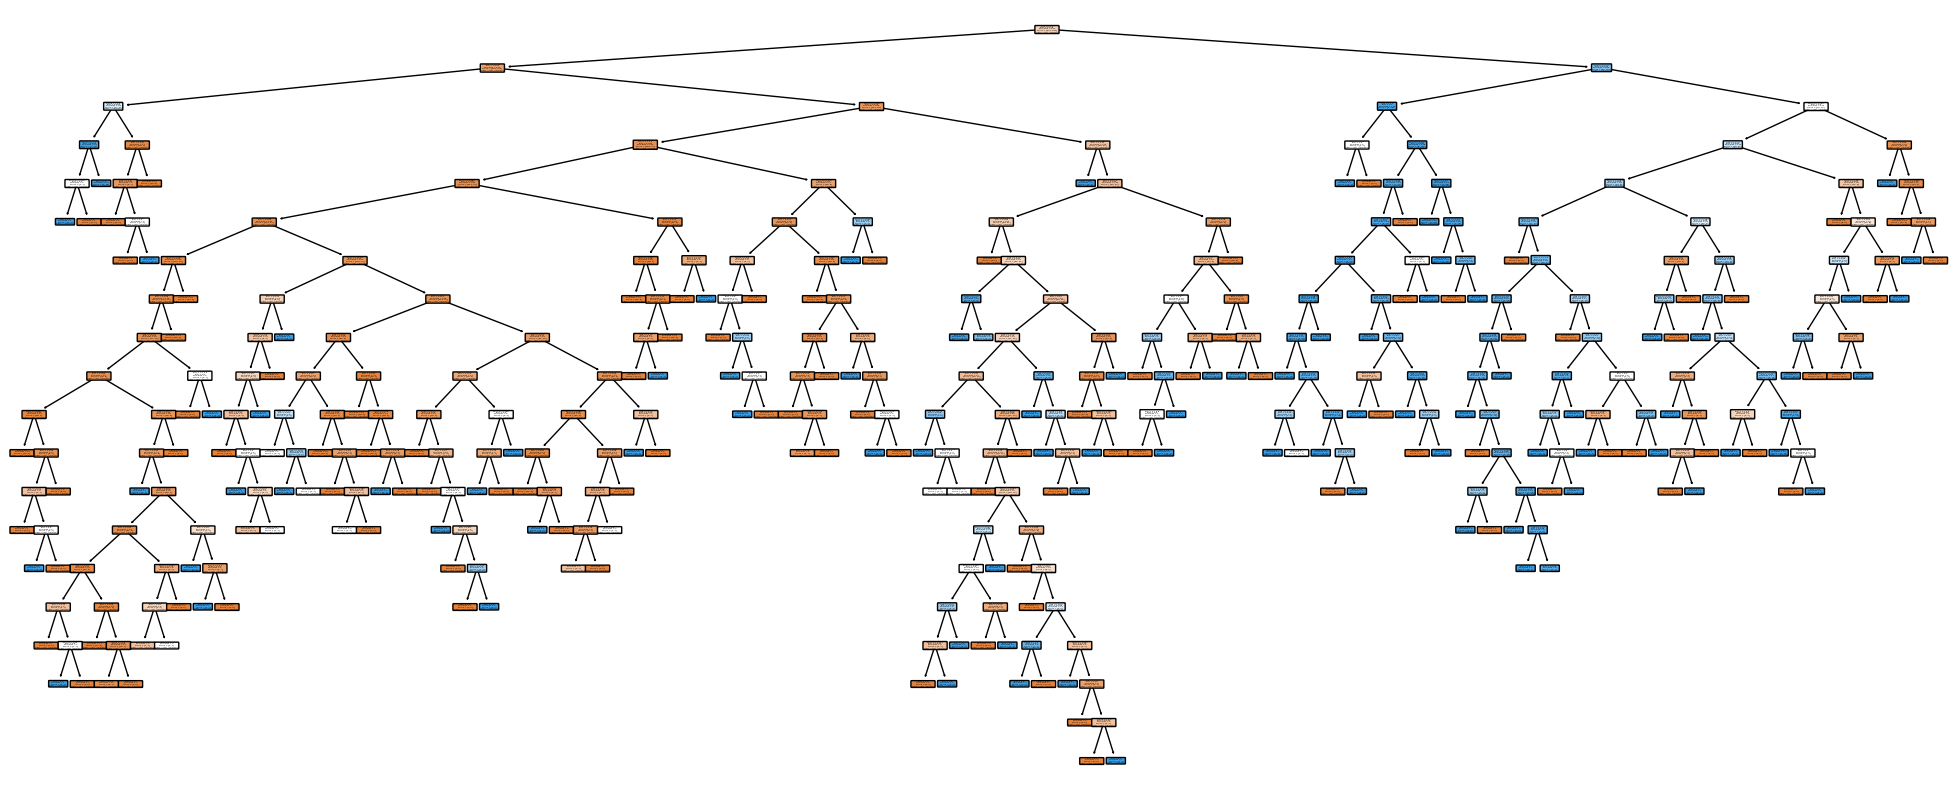

In [161]:
plt.figure(figsize=(25, 10))
plot_tree(mod_dc, 
        filled=True, 
        rounded=True, 
        class_names=['Not_Survived', 'Survived'], 
        feature_names=X_train.columns)

/home/dhonicap/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


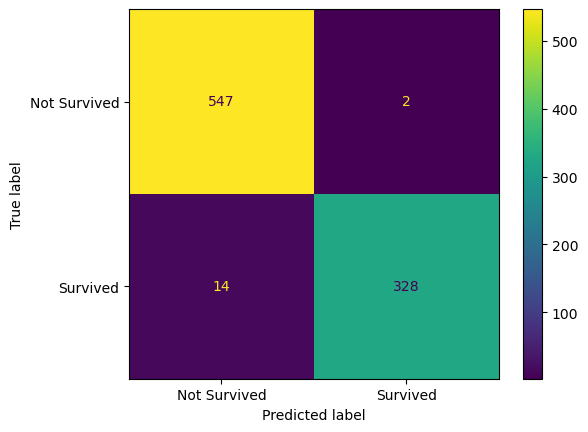

In [118]:
plot_confusion_matrix(mod_dc, X_train, Y_train, display_labels=['Not Survived', 'Survived'])

As you can see the, the tree is **huge**. The text information gives how exaclty the decions are made. But if you see the tree, there are so many decions and so many leaf nodes which might be because the model is trying to ovefit. Decision tress generally overfit and we have to prune the tree.

In [119]:
mod_dc.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

There are two types of pruning. Pre-pruning technique involves tuning few above shown hyper-paramters like `max_depth`, `max_features`, `min_samples_leaf` and `min_samples_split` before training the model. This type of pre-fitting optimization is called early fitting. Other technique is called post-pruning. We typically tune only `ccp_aplha` which stands for Cost Complexity Pruning. It is similar to regularization where aplha is similar to lambda. More the value of aplha more the decion tree is pruned. In our case, we can tune this aplha using our grid search.

In [124]:
#First, we need to find available aplhas
path = mod_dc.cost_complexity_pruning_path(X_train, Y_train)
alphas = path.ccp_alphas
#Removing last value of alphas as it will remove all leaves
alphas = alphas[:-1]
alphas

array([0.00000000e+00, 0.00000000e+00, 2.04060810e-05, 3.11759571e-05,
       4.53468467e-05, 4.67639357e-05, 7.48222970e-05, 7.48222970e-05,
       1.23894063e-04, 1.30939020e-04, 2.24466891e-04, 3.24229954e-04,
       3.36700337e-04, 3.51438062e-04, 3.74111485e-04, 5.41816634e-04,
       5.58673151e-04, 6.39936195e-04, 6.54695099e-04, 6.73400673e-04,
       7.04209855e-04, 7.32303333e-04, 7.35541225e-04, 7.40665163e-04,
       7.48222970e-04, 7.82756338e-04, 7.83279571e-04, 8.16243240e-04,
       8.72926799e-04, 8.97867565e-04, 8.97867565e-04, 9.20889810e-04,
       9.29610357e-04, 9.62000962e-04, 9.62000962e-04, 9.98730955e-04,
       1.01010101e-03, 1.02880658e-03, 1.04216771e-03, 1.06888996e-03,
       1.07009774e-03, 1.07251908e-03, 1.12233446e-03, 1.12233446e-03,
       1.15186957e-03, 1.16950407e-03, 1.19715675e-03, 1.19715675e-03,
       1.19715675e-03, 1.24952911e-03, 1.30939020e-03, 1.30939020e-03,
       1.34182518e-03, 1.44300144e-03, 1.49644594e-03, 1.56446621e-03,
      

We can even try to tune `criterion` which determines how good our split is. Default is `gini` but we can also use `entropy` and `log_loss`. . But mostly `gini` is used so we will stick with that.

In [145]:
mod_dc2 = DecisionTreeClassifier()
grid_dc = GridSearchCV(
    estimator = mod_dc2,
    param_grid={'ccp_alpha': alphas},
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)},
    refit = 'Accuracy' #Inorder to rank the output
)
grid_dc.fit(X_train, Y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.00000000e+00, 0.00000000e+00, 2.04060810e-05, 3.11759571e-05,
       4.53468467e-05, 4.67639357e-05, 7.48222970e-05, 7.48222970e-05,
       1.23894063e-04, 1.30939020e-04, 2.24466891e-04, 3.24229954e-04,
       3.36700337e-04, 3.51438062e-...
       2.24466891e-03, 2.40421646e-03, 2.48458543e-03, 2.65565625e-03,
       2.84448495e-03, 3.13120267e-03, 3.73626008e-03, 3.76073487e-03,
       3.79003919e-03, 4.07860114e-03, 1.12809002e-02, 1.26245950e-02,
       1.44588122e-02, 3.49754571e-02])},
             refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'F1-score': make_scorer(f1_score),
                      'Precision': make_scorer(precision_score),
                      'Recall': make_scorer(recall_score)})

In [147]:
print(grid_dc.best_score_)
grid_dc.best_params_

0.8215980024968788


{'ccp_alpha': 0.0015741833923652096}

In [152]:
mod_dc_pruned = DecisionTreeClassifier(ccp_alpha=0.0015741833923652096)
dc_pruned_scores = cross_validate(
    mod_dc_pruned, X_train, Y_train, cv = kfold, scoring={'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)}
)
mod_dc_pruned_scores = pd.DataFrame(dc_pruned_scores)
mod_dc_pruned_scores

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F1-score
0,0.002542,0.002350,0.788889,0.735294,0.714286,0.724638
1,0.002196,0.010300,0.842697,0.857143,0.705882,0.774194
2,0.003411,0.002381,0.741573,0.720000,0.529412,0.610169
3,0.002447,0.003043,0.797753,0.673913,0.911765,0.775000
4,0.002331,0.002594,0.876404,0.848485,0.823529,0.835821
5,0.002614,0.002409,0.831461,0.787879,0.764706,0.776119
6,0.002315,0.001810,0.820225,0.875000,0.617647,0.724138
7,0.002094,0.001739,0.797753,0.863636,0.558824,0.678571
8,0.002060,0.002825,0.887640,0.815789,0.911765,0.861111
9,0.002399,0.002107,0.831461,0.794118,0.771429,0.782609


In [153]:
mod_dc_pruned_scores['test_Accuracy'].mean()

0.821585518102372

[Text(0.446875, 0.9666666666666667, 'Sex <= 0.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]\nclass = Not_Survived'),
 Text(0.1375, 0.9, 'Age <= 12.75\ngini = 0.306\nsamples = 577\nvalue = [468, 109]\nclass = Not_Survived'),
 Text(0.05, 0.8333333333333334, 'SibSp <= 2.5\ngini = 0.494\nsamples = 38\nvalue = [17, 21]\nclass = Survived'),
 Text(0.025, 0.7666666666666667, 'gini = 0.091\nsamples = 21\nvalue = [1, 20]\nclass = Survived'),
 Text(0.075, 0.7666666666666667, 'gini = 0.111\nsamples = 17\nvalue = [16, 1]\nclass = Not_Survived'),
 Text(0.225, 0.8333333333333334, 'Fare <= 3.268\ngini = 0.273\nsamples = 539\nvalue = [451, 88]\nclass = Not_Survived'),
 Text(0.125, 0.7666666666666667, 'Em_C <= 0.5\ngini = 0.184\nsamples = 399\nvalue = [358, 41]\nclass = Not_Survived'),
 Text(0.1, 0.7, 'gini = 0.164\nsamples = 354\nvalue = [322, 32]\nclass = Not_Survived'),
 Text(0.15, 0.7, 'Fare <= 2.718\ngini = 0.32\nsamples = 45\nvalue = [36, 9]\nclass = Not_Survived'),
 Text(0.125, 0.63333333333

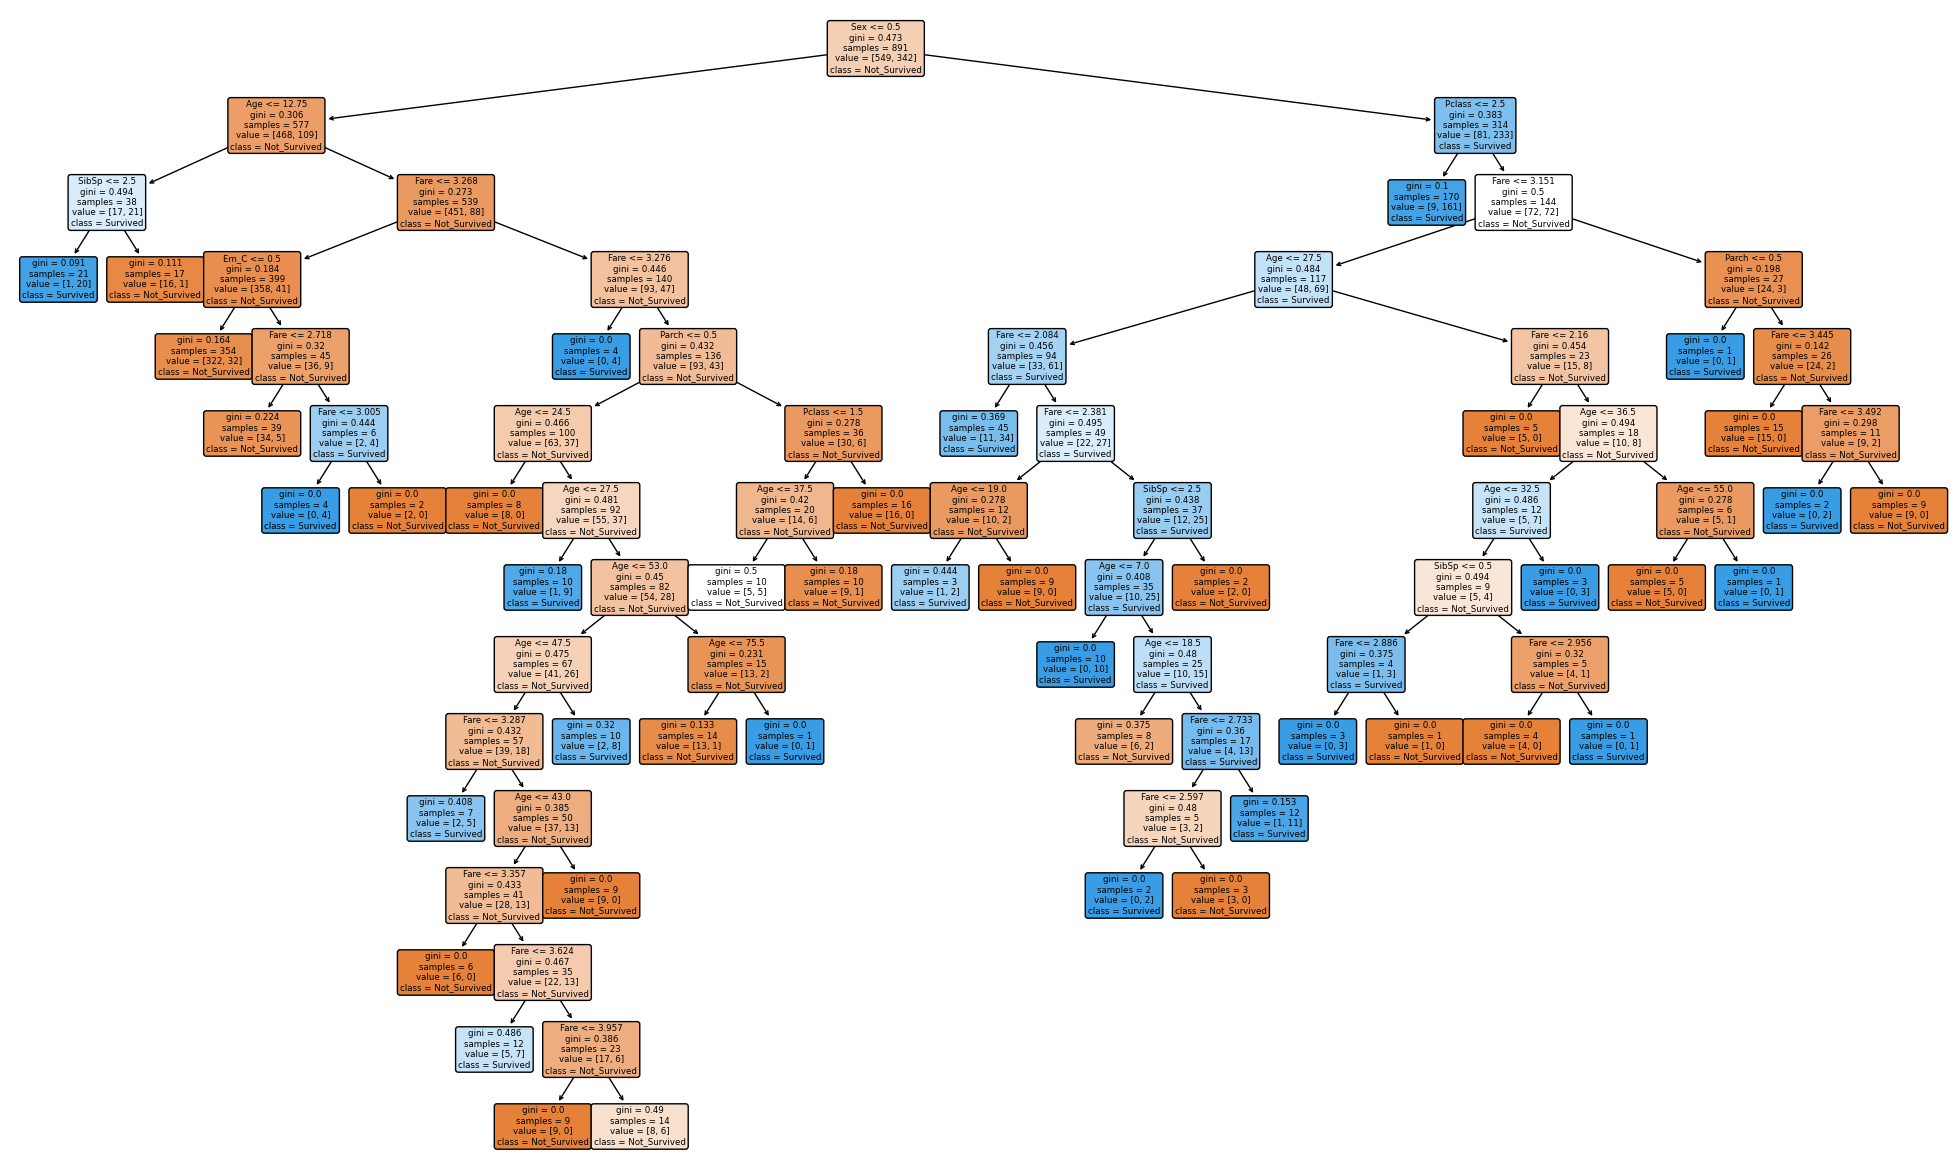

In [163]:
mod_dc_pruned = mod_dc_pruned.fit(X_train, Y_train)
plt.figure(figsize=(25, 15))
plot_tree(mod_dc_pruned, 
        filled=True, 
        rounded=True, 
        class_names=['Not_Survived', 'Survived'], 
        feature_names=X_train.columns)

As we can see, the tree is pruned and performance is at its highest.